In [1]:
import math
import numpy as np
import json
import pandas as pd
import glob

from src.constants import OUTPUTS_DIR

In [2]:
experiment_file_1 = OUTPUTS_DIR / "train_turbo_table_bcjr_renorm_train_snr copy.json"

exp_files = [experiment_file_1]

In [5]:
training_runs = []
validation_runs = []
for exp_file in exp_files:
    with open(exp_file, "r") as e:
        results = json.load(e)
    for d in results["data"]:
        if "results" not in d:
            continue
            
        training_results = pd.DataFrame([res for res in d["results"] if res["type"] == "training"])
        validation_results = pd.DataFrame([{**res, "step": (d["results"][i-1]["step"] + 1 if i > 0 else 0)} for i, res in enumerate(d["results"]) if res["type"] == "validation"])
        preambles = pd.DataFrame([{**d["preamble"]["args"], **d["preamble"]}])
        training_results = training_results.merge(preambles, how="cross")
        validation_results = validation_results.merge(preambles, how="cross")
        
        
        training_runs.append(training_results)
        validation_runs.append(validation_results)

training = pd.concat(training_runs, axis=0)
validation = pd.concat(validation_runs, axis=0)

arg_select_cols = ["adam_lr", "block_len", "snr", "init_method", "window","num_iter", "use_max", "renormalize_table", "argument_hash"]
training_select_cols = ["xe", "ber", "bler", "step"]
val_select_cols = ["xe__mean", "ber__mean", "bler__mean", "xe__err", "ber__err", "bler__err", "step", ]

training = training[training_select_cols + arg_select_cols]
validation = validation[val_select_cols + arg_select_cols]

# lr_filter = [0.01]
# training = training[training["adam_lr"].isin(lr_filter)]
# validation = validation[validation["adam_lr"].isin(lr_filter)]

display(training.head())
display(validation.head())

,xe,ber,bler,step,adam_lr,block_len,snr,init_method,window,num_iter,use_max,renormalize_table,argument_hash
0,0.002424,0.000723,0.057617,0,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
1,0.002534,0.000830,0.062500,1,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
2,0.001728,0.000713,0.060547,2,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
3,0.002432,0.000635,0.050781,3,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
4,0.001623,0.000615,0.056641,4,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b


,xe__mean,ber__mean,bler__mean,xe__err,ber__err,bler__err,step,adam_lr,block_len,snr,init_method,window,num_iter,use_max,renormalize_table,argument_hash
0,0.013371,0.004444,0.267090,0.000692,0.000185,0.008745,0,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
1,0.005762,0.001702,0.119531,0.000481,0.000109,0.006412,50,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
2,0.003999,0.001196,0.087500,0.000403,0.000088,0.005585,100,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
3,0.003498,0.001023,0.072559,0.000406,0.000084,0.005127,150,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b
4,0.003281,0.000880,0.061914,0.000475,0.000081,0.004763,200,0.01,100,4.0,normal,5,5,True,True,bd8a9e3b586ebe4bc26ce7ae0d00c938a9af4e8b


/tmp/ipykernel_23999/3887237004.py:41: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


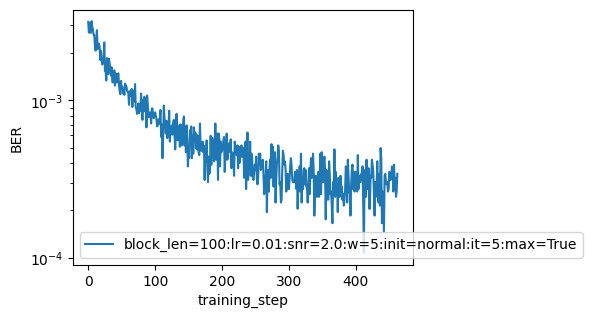

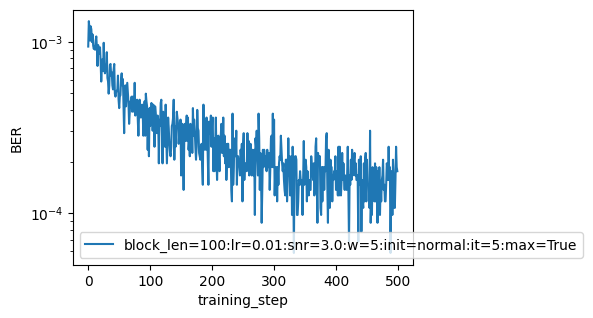

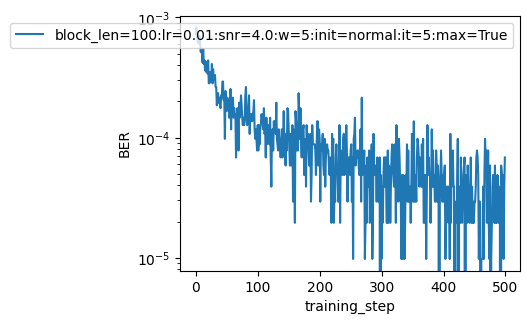

In [7]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (lr, block_len, snr, window, init_method, num_iter, use_max, renormalize_table, argument_hash), training_result in training.groupby(["adam_lr", "block_len", "snr", "window", "init_method", "num_iter", "use_max", "renormalize_table", "argument_hash"]):
    if len(training_result) < 100:
        continue
    
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    
    ax.errorbar(
        training_result["step"], 
        training_result["ber"], 
        # yerr=exp_result["xe__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:lr={lr}:snr={snr}:w={window}:init={init_method}:it={num_iter}:max={use_max}"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('BER')

    fig.show()

/tmp/ipykernel_23999/405134704.py:62: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


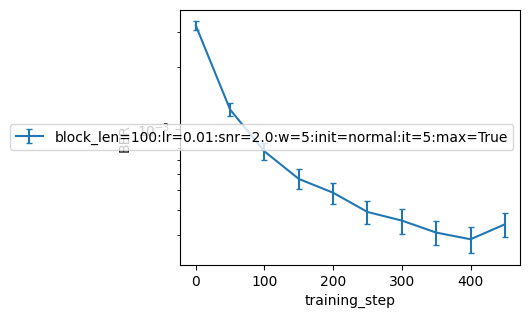

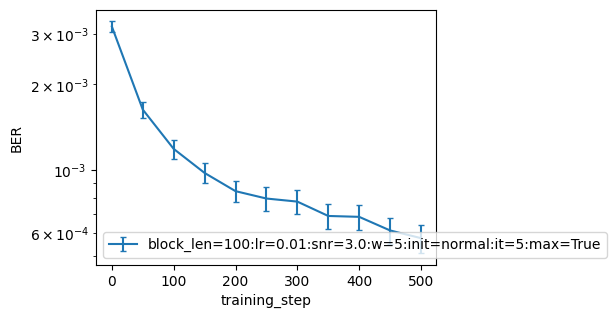

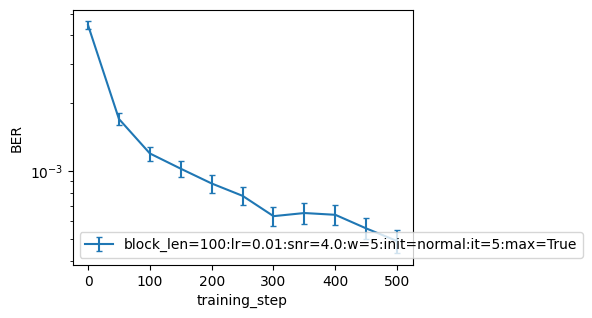

In [11]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

# fig = plt.figure(figsize=(8, 6), dpi=100)
# ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
# capsize = 2

# for (snr, decoder_type, enc_name), exp_result in exp_results.groupby(["snr", "decoder_type", "encoder_name"]):
#     ax.errorbar(
#         exp_result["block_len"][:10], 
#         exp_result["xe__mean"][:10], 
#         yerr=exp_result["xe__err"][:10], 
#         linestyle='-',
#         capsize=capsize,
#         label=f"{enc_name}:{decoder_type}:snr={snr}"
#     )

for (
    lr, 
    block_len, 
    snr, 
    window, 
    init_method, 
    num_iter, 
    use_max, 
    renormalize_table, 
    argument_hash
), validation_result in validation.groupby(
    [
        "adam_lr", 
        "block_len", 
        "snr", 
        "window", 
        "init_method", 
        "num_iter", 
        "use_max", 
        "renormalize_table", 
        "argument_hash"
    ]):
    if len(validation_result) < 2:
        continue
    
    fig = plt.figure(figsize=(4, 3), dpi=100)
    ax = fig.add_axes([0.1, 0.1, .85, .85])  # Last two terms control height and width
    capsize = 2
    
    ax.errorbar(
        validation_result["step"], 
        validation_result["ber__mean"], 
        yerr=validation_result["ber__err"], 
        linestyle='-',
        capsize=capsize,
        label=f"block_len={block_len}:lr={lr}:snr={snr}:w={window}:init={init_method}:it={num_iter}:max={use_max}"
    )
    ax.legend()
    ax.set_yscale('log')
    # ax.set_xscale('log')
    ax.set_xlabel('training_step')
    ax.set_ylabel('BER')

    fig.show()